# Exploratory analysis

The purpose of exploratory analysis is to understand your data and any idiosyncrasies which may be relevant to the task of data linking.

Splink includes functionality to visualise and summarise your data, to identify characteristics most salient to data linking.

In this notebook we perform some basic exploratory analysis, and interpret the results.

### Read in the data

For the purpose of this tutorial we will use a 1,000 row synthetic dataset that contains duplicates.

The first five rows of this dataset are printed below.

Note that the cluster column represents the 'ground truth' - a column which tells us with which rows refer to the same person. In most real linkage scenarios, we wouldn't have this column (this is what Splink is trying to estimate.)

In [2]:
import pandas as pd 
import altair as alt
alt.renderers.enable('mimetype')

df = pd.read_csv("./data/fake_1000.csv")
df.head(5)

,unique_id,first_name,surname,dob,city,email,cluster
0,0,Robert,Alan,1971-06-24,NaN,robert255@smith.net,0
1,1,Robert,Allen,1971-05-24,NaN,roberta25@smith.net,0
2,2,Rob,Allen,1971-06-24,London,roberta25@smith.net,0
3,3,Robert,Alen,1971-06-24,Lonon,NaN,0
4,4,Grace,NaN,1997-04-26,Hull,grace.kelly52@jones.com,1


### Instantiate the linker

Most of Splink's core functionality can be accessed as methods on a linker object.  For example, to make predictions, you would call `linker.predict()`.

We therefore begin by instantiating the linker, passing in the data we wish to deduplicate.

In [3]:
# Initialise the linker, passing in the input dataset(s)
from splink.duckdb.duckdb_linker import DuckDBLinker
linker = DuckDBLinker(df)

/var/folders/d2/20f6jnm54qd_4jq525w_7j_h0000gp/T/ipykernel_83558/1741392168.py:2: SplinkDeprecated: Importing directly from `splink.duckdb.duckdb_linker` is deprecated and will be removed in Splink v4. Please import from `splink.duckdb.linker` going forward.
  from splink.duckdb.duckdb_linker import DuckDBLinker


## Analyse missingness

It's important to understand the level of missingness in your data, because columns with higher levels of missingness are less useful for data linking.

In [4]:
linker.missingness_chart()

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


The above summary chart shows that in this dataset, the `email`, `city`, `surname` and `forename` columns contain nulls, but the level of missingness is relatively low (less than 22%).

## Analyse the distribution of values in your data

The distribution of values in your data is important for two main reasons:

1. Columns with higher cardinality (number of distinct values) are usually more useful for data linking.  For instance, date of birth is a much stronger linkage variable than gender.

2. The skew of values is important.  If you have a `city` column that has 1,000 distinct values, but 75% of them are `London`, this is much less useful for linkage than if the 1,000 values were equally distributed

The `linker.profile_columns()` method creates summary charts to help you understand these aspects of your data. 

To profile all columns, leave the column_expressions argument empty.

In [5]:
linker.profile_columns(top_n = 10, bottom_n = 5)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Alternatively, we can profile columns specifically by inputting their column names within a list. This input also allows for arbitary sql expressions like `concat(first_name, surname)`.  

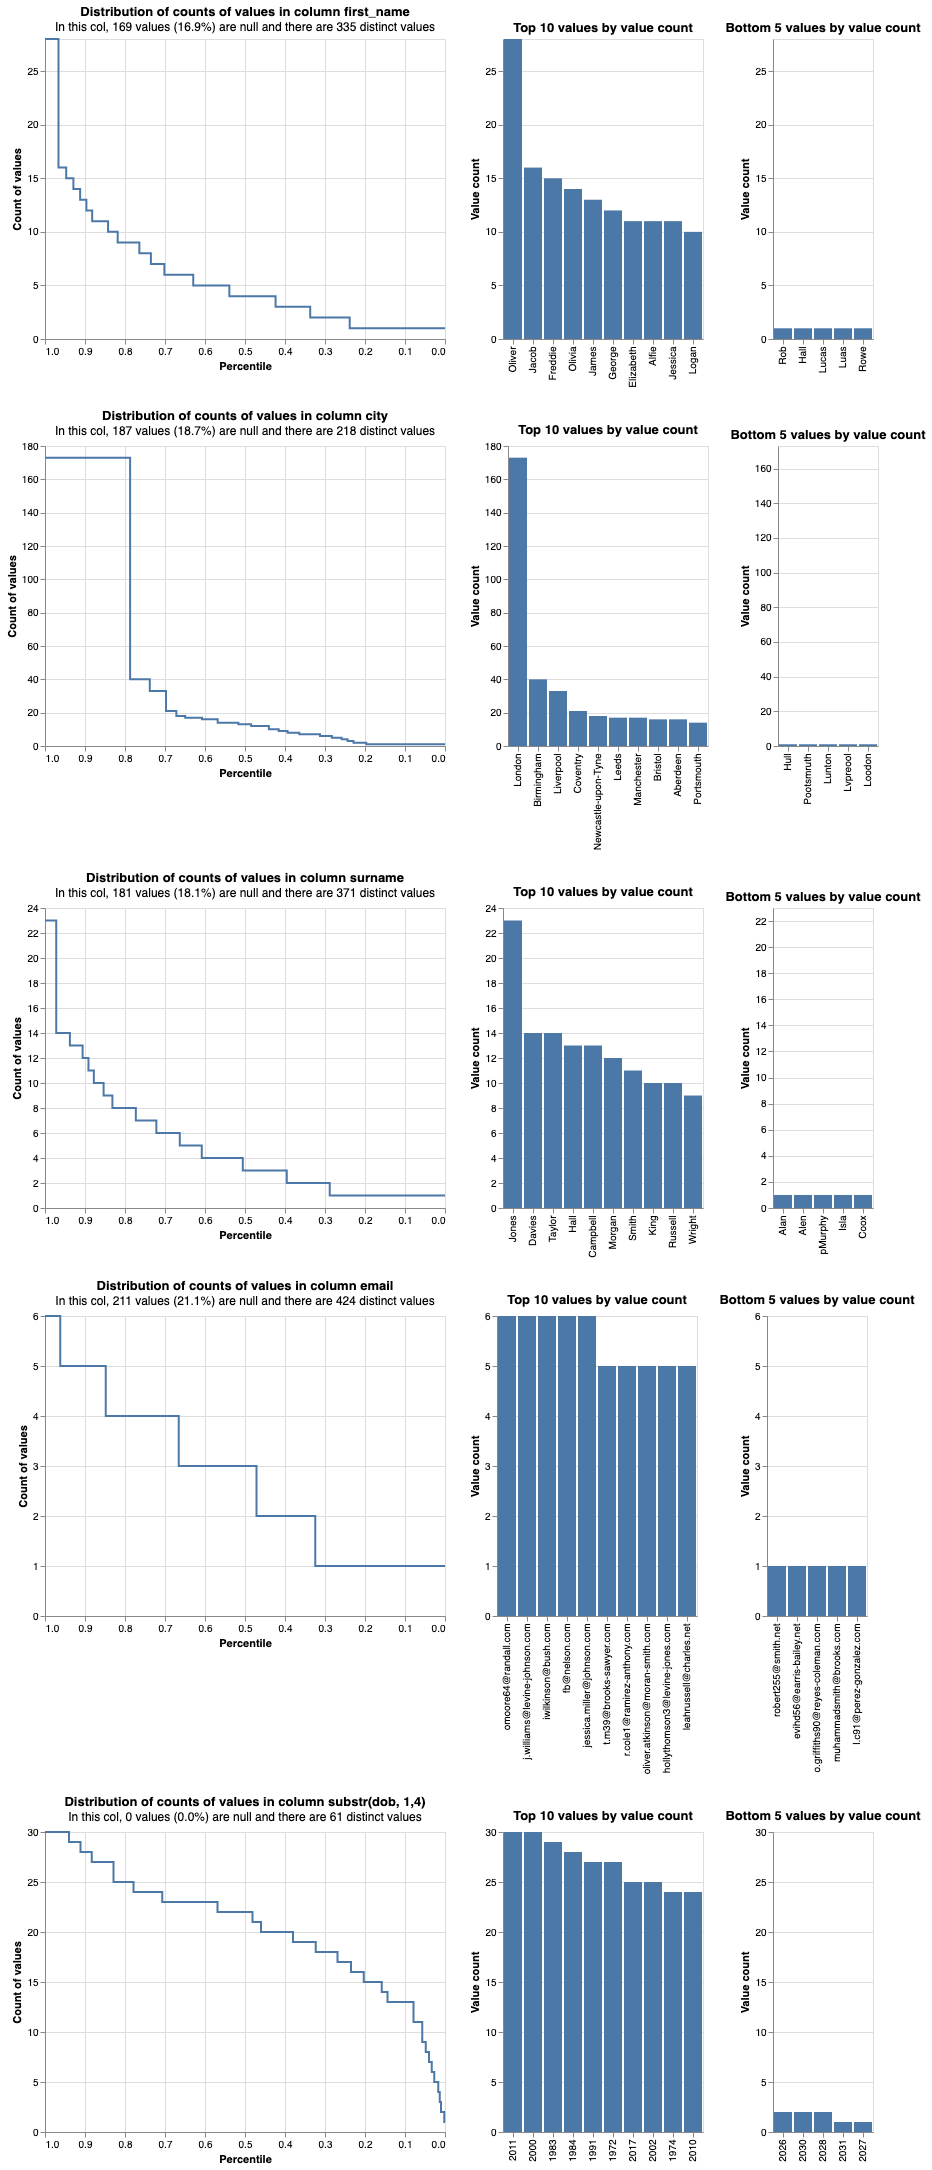

In [4]:
linker.profile_columns(["substr(dob, 1,4)"], top_n=10, bottom_n=5)

This chart is very information-dense, but here are some key takehomes relevant to our linkage:

- There is strong skew in the `city` field with around 20% of the values being `London`.  We therefore will probably want to use `term_frequency_adjustments` in our linkage model, so that it can weight a match on London differently to a match on, say, `Norwich`.

- Looking at the "Bottom 5 values by value count", we can see typos in the data in most fields.  This tells us this information was possibly entered by hand, or using Optical Character Recognition, giving us an insight into the type of data entry errors we may see.

- Email is a much more uniquely-identifying field than any others, with a maximum value count of 6.  It's likely to be a strong linking variable.

## Next steps

At this point, we have begin to develop a strong understanding of our data.  It's time to move on to estimating a linkage model


## Further reading

You can find the documentation for the exploratory analysis tools in Splink [here](https://moj-analytical-services.github.io/splink/linkerexp.html)